In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

RANDOM_SEED = 2024


In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [7]:
X_columns_original = [col for col in train.columns if col != 'Premium Amount']

In [8]:
X_columns_original

['id',
 'Age',
 'Gender',
 'Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Education Level',
 'Occupation',
 'Health Score',
 'Location',
 'Policy Type',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type']

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

# Data Preprocessing 

In [10]:
train['Log Premium Amount'] = np.log(train['Premium Amount']+1)

### Skewness of numerical features

number of columns : 10
num rows = 3, num cols = 4


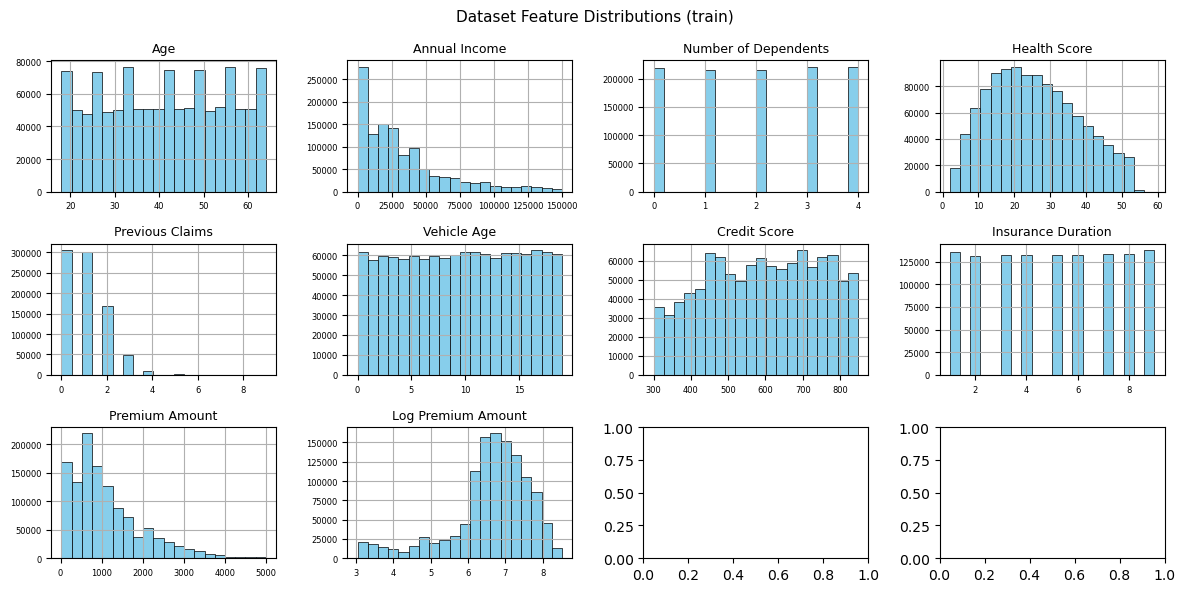

In [11]:
def plot_feature_distribution(df):
    print(f'number of columns : {len(df.columns)}')
    nrows = int(np.ceil(len(df.columns)/4))
    ncols = int(np.ceil(len(df.columns) / nrows))
    print(f'num rows = {nrows}, num cols = {ncols}')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows))
    columns_to_plot = df.columns
    for i, column in enumerate(columns_to_plot):
        ax = axes.flatten()[i]
        df[column].hist(ax=ax, bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
        ax.set_title(column, fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=6)
    plt.suptitle('Dataset Feature Distributions (train)', fontsize=11)
    plt.tight_layout()
    plt.show()

plot_feature_distribution(train.select_dtypes(include = 'float64'))

`Annual Income` and `Health Score` are positively skewed, apply one of these three transformations:
- Logarithmic
- Square Root
- Box-Cox

In [12]:
train['Log Annual Income'] = np.log(train['Annual Income'])
train['SQRT Annual Income'] = np.sqrt(train['Annual Income'])
_, annual_income_lmbda =  boxcox(train['Annual Income'].dropna()) # need to apply on non-null values

In [13]:
def boxcox_with_lmbda(lmbda, value):
    '''
    Work-around for inference with boxcox using given lmbda on series with np.nan values
    '''
    if lmbda != 0:
        return (value**lmbda - 1) / lmbda
    else:
        return np.log(value)


train['Boxcox Annual Income'] = train['Annual Income'].apply(lambda val: boxcox_with_lmbda(annual_income_lmbda, val))

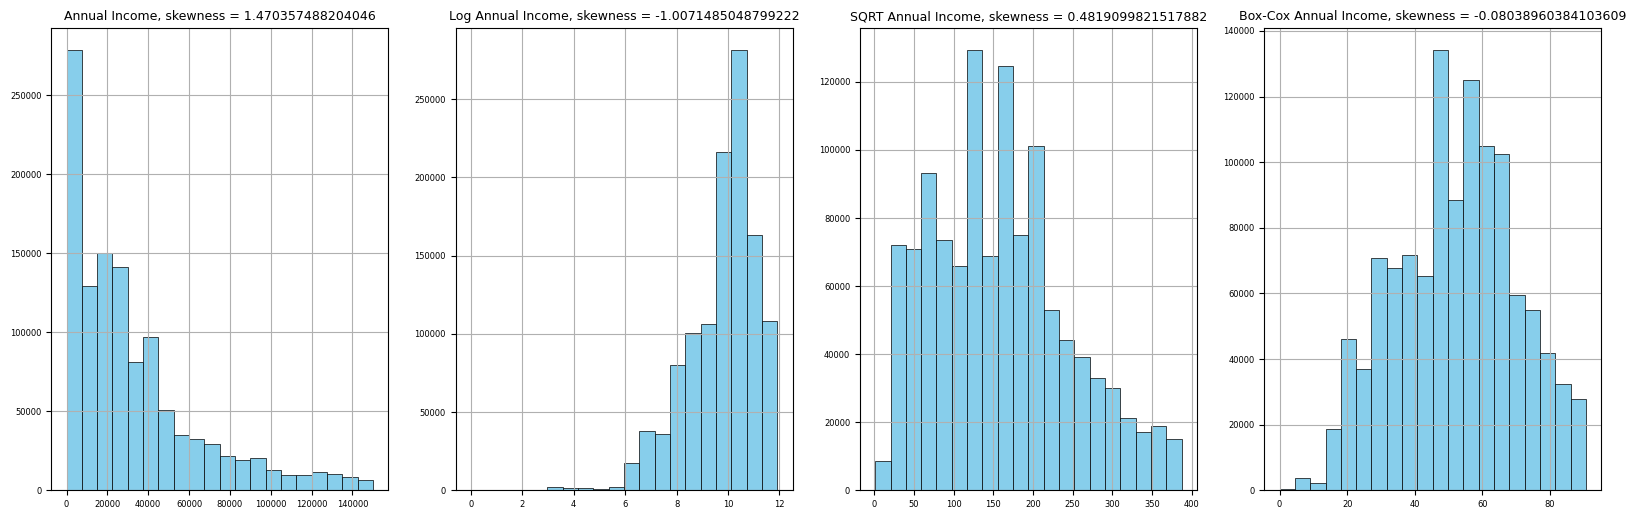

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

train['Annual Income'].hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].set_title(f'Annual Income, skewness = {train["Annual Income"].skew()}', fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=6)

train['Log Annual Income'].hist(ax=axes[1], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[1].set_title(f'Log Annual Income, skewness = {train["Log Annual Income"].skew()}', fontsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=6)

train['SQRT Annual Income'].hist(ax=axes[2], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[2].set_title(f'SQRT Annual Income, skewness = {train["SQRT Annual Income"].skew()}', fontsize=9)
axes[2].tick_params(axis='both', which='major', labelsize=6)

train['Boxcox Annual Income'].hist(ax=axes[3], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[3].set_title(f'Box-Cox Annual Income, skewness = {train["Boxcox Annual Income"].skew()}', fontsize=9)
axes[3].tick_params(axis='both', which='major', labelsize=6)

In [15]:
train['Log Health Score'] = np.log(train['Health Score'])
train['SQRT Health Score'] = np.sqrt(train['Health Score'])
_, health_score_lmbda =  boxcox(train['Health Score'].dropna()) # need to apply on non-null values

train['Boxcox Health Score'] = train['Health Score'].apply(lambda val: boxcox_with_lmbda(health_score_lmbda, val))

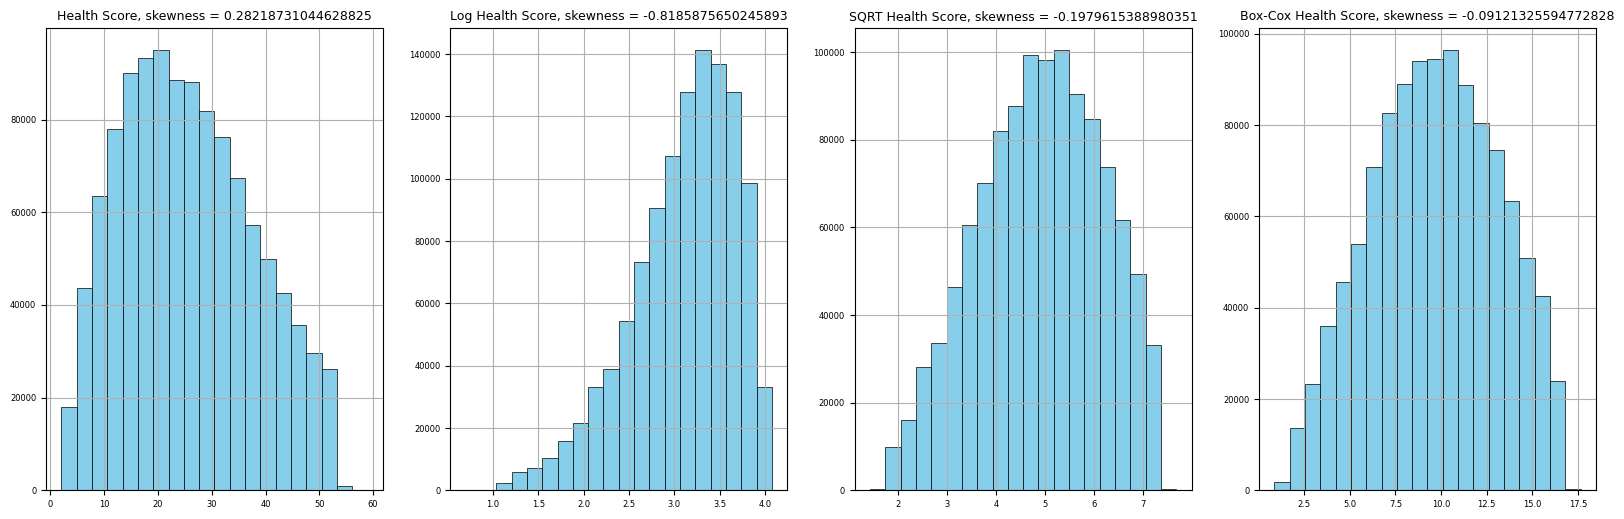

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

train['Health Score'].hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[0].set_title(f'Health Score, skewness = {train["Health Score"].skew()}', fontsize=9)
axes[0].tick_params(axis='both', which='major', labelsize=6)

train['Log Health Score'].hist(ax=axes[1], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[1].set_title(f'Log Health Score, skewness = {train["Log Health Score"].skew()}', fontsize=9)
axes[1].tick_params(axis='both', which='major', labelsize=6)

train['SQRT Health Score'].hist(ax=axes[2], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[2].set_title(f'SQRT Health Score, skewness = {train["SQRT Health Score"].skew()}', fontsize=9)
axes[2].tick_params(axis='both', which='major', labelsize=6)

train['Boxcox Health Score'].hist(ax=axes[3], bins=20, color='skyblue', edgecolor='black', linewidth=0.5)
axes[3].set_title(f'Box-Cox Health Score, skewness = {train["Boxcox Health Score"].skew()}', fontsize=9)
axes[3].tick_params(axis='both', which='major', labelsize=6)

### Periodic Encoding for `Policy Start Date`

In [17]:
# Example
datetime = train['Policy Start Date'].values[0]
print(f'Raw format: {datetime}')

datetime = pd.to_datetime(datetime).date()
print(f'Transformed: {datetime}')

print(f'year: {datetime.year}, month: {datetime.month}, day: {datetime.day}')

Raw format: 2023-12-23 15:21:39.134960
Transformed: 2023-12-23
year: 2023, month: 12, day: 23


In [18]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['Policy Start Date'] = train['Policy Start Date'].apply(lambda dt: dt.date())

train['Policy Start Year'] = train['Policy Start Date'].apply(lambda dt: dt.year)

train['Policy Start Month'] = train['Policy Start Date'].apply(lambda dt: dt.month)
train['Policy Start Month_sin'] = np.sin(2 * np.pi * train['Policy Start Month'] / 12)
train['Policy Start Month_cos'] = np.cos(2 * np.pi * train['Policy Start Month'] / 12)

train['Policy Start Day'] = train['Policy Start Date'].apply(lambda dt: dt.day)

### Impute Missing Values

##### Helper Function

In [19]:
# Highlight rows with more than 5% missing values
def highlight_high_missing_values(val, threshold):
    if float(val.strip('%')) > threshold:
        color = 'red'
    elif float(val.strip('%')) <= threshold and float(val.strip('%')) > 0:
        color = 'yellow'
    else:
        color = None
    return f'color: {color}'

def inspectMissingValues(df, threshold = 5):
    '''
    Calculate the number and portion of missing values in each column of df
    highlight those with missing value portion > (threshold %)
    '''
    # Count of missing values
    missing_values_count = df.isnull().sum()

    # Proportion of missing values
    total_observations = df.shape[0]
    missing_values_proportion = missing_values_count / total_observations

    
    missing_data_summary = pd.DataFrame({
        'Missing Values Count': missing_values_count,
        'Proportion (%)': missing_values_proportion.map(lambda x: f'{x:.4%}'),
        'Data Type': df.dtypes
    })
    
    missing_data_summary = missing_data_summary.style.applymap(lambda val: highlight_high_missing_values(val, threshold), subset=['Proportion (%)'])

    return missing_data_summary

In [20]:
inspectMissingValues(train[X_columns_original])

,Missing Values Count,Proportion (%),Data Type
id,0,0.0000%,int64
Age,18705,1.5588%,float64
Gender,0,0.0000%,object
Annual Income,44949,3.7457%,float64
Marital Status,18529,1.5441%,object
Number of Dependents,109672,9.1393%,float64
Education Level,0,0.0000%,object
Occupation,358075,29.8396%,object
Health Score,74076,6.1730%,float64
Location,0,0.0000%,object


##### Impute Missing Categorical Features

- `Marital Status`
- `Occupation`
- `Customer Feedback`

number of columns : 3
num rows = 1, num cols = 3


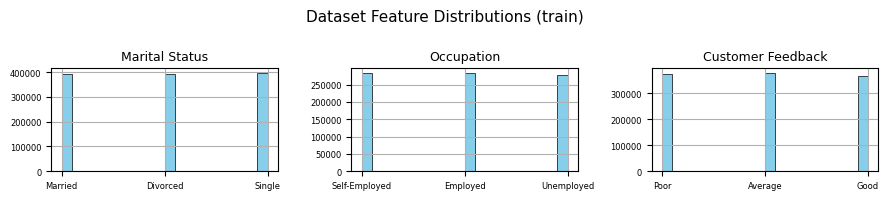

In [21]:
plot_feature_distribution(train[['Marital Status', 'Occupation', 'Customer Feedback']])

In [22]:
#Marital Status & Customer Feedback: missing values ~ Uniform(all classes)

def uniform_random_impute(df, col, is_numerical=False, is_integer = False, min_val=None, max_val=None):
    np.random.seed(RANDOM_SEED)
    
    missing_mask = df[col].isnull()
    num_missing = missing_mask.sum()

    if is_numerical:
        # Numerical
        imputed_values = np.random.uniform(min_val, max_val, num_missing)

        if is_integer:
            imputed_values = imputed_values.round()
    else:
        # Categorical
        categories = df[col].dropna().unique()
        imputed_values = np.random.choice(categories, size=missing_mask.sum())
    
    df.loc[missing_mask, col] = imputed_values

In [23]:
uniform_random_impute(train, 'Marital Status')
uniform_random_impute(train, 'Customer Feedback')

In [24]:
train['Customer Feedback'].isnull().sum(), train['Marital Status'].isnull().sum()

(0, 0)

In [25]:
# Occupation: Create new class as "Unknown"
occ_imputer = SimpleImputer(strategy = "constant", fill_value = "Unknown")
transformed_value = occ_imputer.fit_transform(train['Occupation'].values.reshape(-1,1))
train['Occupation'] = transformed_value.squeeze(-1)

In [26]:
inspectMissingValues(train[X_columns_original])

,Missing Values Count,Proportion (%),Data Type
id,0,0.0000%,int64
Age,18705,1.5588%,float64
Gender,0,0.0000%,object
Annual Income,44949,3.7457%,float64
Marital Status,0,0.0000%,object
Number of Dependents,109672,9.1393%,float64
Education Level,0,0.0000%,object
Occupation,0,0.0000%,object
Health Score,74076,6.1730%,float64
Location,0,0.0000%,object


##### Impute Missing Numerical Feature


- `Insurance Duration`
- `Vehicle Age`
- `Age`
- `Annual Income`
- `Health Score`
- `Number of Dependents`
- `Previous Claims`
- `Credit Score`

There is no obvious dependency among these features. We impute each feature according to its distribution.


number of columns : 8
num rows = 2, num cols = 4


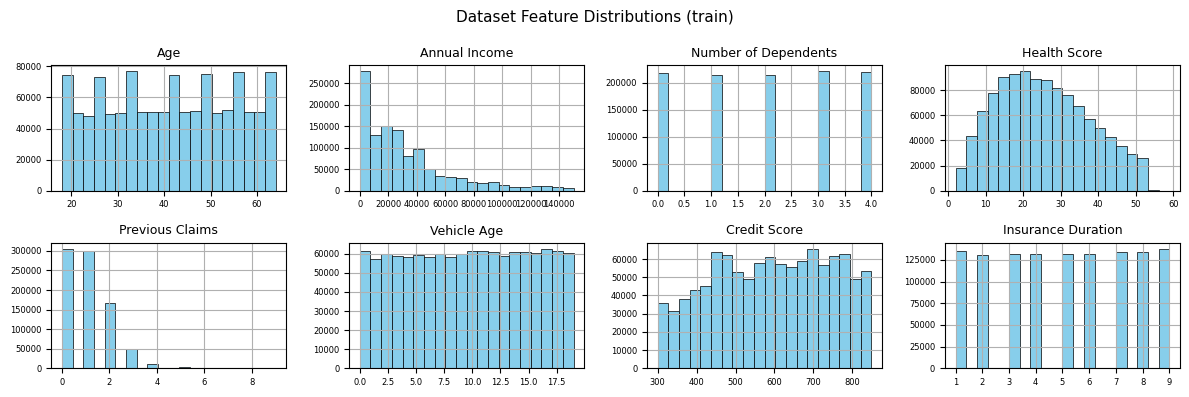

In [27]:
plot_feature_distribution(train[['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']])

In [28]:
# Previous Claims has a spike distribution
# explicitly use the distribution of existing elements to generate samples for missing values
np.random.seed(RANDOM_SEED)

prv_claim_dist = train['Previous Claims'].value_counts() / len(train['Previous Claims'].dropna())
sampled_values = np.random.choice(prv_claim_dist.index, size=train['Previous Claims'].isnull().sum(), p=prv_claim_dist)
train.loc[train['Previous Claims'].isnull(), 'Previous Claims'] = sampled_values

In [29]:
# Uniform distribution for Age, Number of Dependents, Vehicle Age, Insurance Duration

for col in ['Age', 'Number of Dependents', 'Vehicle Age', 'Insurance Duration']:
    uniform_random_impute(train, col = col, is_numerical=True, is_integer=True, min_val=train[col].min(), max_val=train[col].max())

In [30]:
# Normal Distribution for Credit Score, Box Cox Health Score, Box-Cox Annual Income

def normal_random_impute(df, col, is_integer=False, mean=0, std=1):

    np.random.seed(RANDOM_SEED)

    # Impute missing numerical values with samples from a normal distribution
    missing_mask = df[col].isnull()
    num_missing = missing_mask.sum()
    
    imputed_values = np.random.normal(mean, std, num_missing)

    if is_integer:
        imputed_values = imputed_values.round()
        
    imputed_values = np.abs(imputed_values) # since we are working on boxcox value
    df.loc[missing_mask, col] = imputed_values

In [31]:
train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'Log Premium Amount',
       'Log Annual Income', 'SQRT Annual Income', 'Boxcox Annual Income',
       'Log Health Score', 'SQRT Health Score', 'Boxcox Health Score',
       'Policy Start Year', 'Policy Start Month', 'Policy Start Month_sin',
       'Policy Start Month_cos', 'Policy Start Day'],
      dtype='object')

In [32]:
normal_random_impute(train, 'Credit Score', is_integer=True, mean = train['Credit Score'].mean(), std = train['Credit Score'].std())
normal_random_impute(train, 'Boxcox Annual Income', is_integer=False, mean = train['Boxcox Annual Income'].mean(), std = train['Boxcox Annual Income'].std())
normal_random_impute(train, 'Boxcox Health Score', is_integer=False, mean = train['Boxcox Health Score'].mean(), std = train['Boxcox Health Score'].std())


In [33]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return np.exp(y)
   else:
      return np.exp(np.log(np.maximum(lmbda*y+1, 0.01))/lmbda)

In [34]:
train['Health Score'] = invboxcox(train['Boxcox Health Score'], health_score_lmbda)
train['Annual Income'] = invboxcox(train['Boxcox Annual Income'], annual_income_lmbda)

In [35]:
train[X_columns_original].isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

### Encode Categorical Features

In [36]:
cat_columns = train.select_dtypes(include = "object").columns

for col in cat_columns:
    print(f'{col}: {train[col].dropna().unique()}')

Gender: ['Female' 'Male']
Marital Status: ['Married' 'Divorced' 'Single']
Education Level: ["Bachelor's" "Master's" 'High School' 'PhD']
Occupation: ['Self-Employed' 'Unknown' 'Employed' 'Unemployed']
Location: ['Urban' 'Rural' 'Suburban']
Policy Type: ['Premium' 'Comprehensive' 'Basic']
Policy Start Date: [datetime.date(2023, 12, 23) datetime.date(2023, 6, 12)
 datetime.date(2023, 9, 30) ... datetime.date(2019, 11, 21)
 datetime.date(2023, 5, 4) datetime.date(2022, 1, 28)]
Customer Feedback: ['Poor' 'Average' 'Good']
Smoking Status: ['No' 'Yes']
Exercise Frequency: ['Weekly' 'Monthly' 'Daily' 'Rarely']
Property Type: ['House' 'Apartment' 'Condo']


The following features are ordinal:
- `Education Level`
- `Customer Feedback`
- `Smoking Status`
- `Exercise Frequency`

Use integer to encode these features

In [37]:
def encode_ordinal_feature(column, cat_order, df):
    encoder = OrdinalEncoder(categories=[cat_order], handle_unknown='use_encoded_value', unknown_value = np.nan)
    df[f'{column}_ordinal encoding'] = encoder.fit_transform(df[[column]]).reshape(-1,)

In [38]:
ordinal_columns_to_order = {'Education Level': ['High School', "Bachelor's","Master's", "PhD"], 
                            'Customer Feedback': ['Poor','Average','Good'],
                            'Smoking Status': ['No','Yes'],
                            "Exercise Frequency": ['Rarely', 'Daily', 'Weekly','Monthly']}


In [39]:
for col in ordinal_columns_to_order:
    encode_ordinal_feature(col, ordinal_columns_to_order[col], train)

The following features are nominal:
- `Gender`
- `Marital Status`
- `Occupation`
- `Location`
- `Policy Type`
- `Property Type`

In [40]:
nominal_cat_columns = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Policy Type', 'Property Type']
for col in nominal_cat_columns:
    train = pd.concat([train, pd.get_dummies(train[col], dtype='float64', prefix=col)], axis = 1)

train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Policy Type_Basic,Policy Type_Comprehensive,Policy Type_Premium,Property Type_Apartment,Property Type_Condo,Property Type_House
0,0,19.0,Female,10049.000000,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,39.0,Female,31678.000000,Divorced,3.0,Master's,Unknown,15.569731,Rural,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,23.0,Male,25602.000000,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3,21.0,Male,141855.000000,Married,2.0,Bachelor's,Unknown,10.938144,Rural,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,4,21.0,Male,39651.000000,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,Female,27316.000000,Married,0.0,Master's,Unemployed,13.772907,Urban,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1199996,1199996,54.0,Male,35786.000000,Divorced,2.0,Master's,Self-Employed,11.483482,Rural,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1199997,1199997,19.0,Male,51884.000000,Divorced,0.0,Master's,Unknown,14.724469,Suburban,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1199998,1199998,55.0,Male,58901.910487,Single,1.0,PhD,Unknown,18.547381,Suburban,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [41]:
# Repeat the whole procedure for test

np.random.seed(RANDOM_SEED)

# Skewness
test['Boxcox Annual Income'] = test['Annual Income'].apply(lambda val: boxcox_with_lmbda(annual_income_lmbda, val))
test['Boxcox Health Score'] = test['Health Score'].apply(lambda val: boxcox_with_lmbda(health_score_lmbda, val))

# Date time periodic encoding
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['Policy Start Date'] = test['Policy Start Date'].apply(lambda dt: dt.date())

test['Policy Start Year'] = test['Policy Start Date'].apply(lambda dt: dt.year)

test['Policy Start Month'] = test['Policy Start Date'].apply(lambda dt: dt.month)
test['Policy Start Month_sin'] = np.sin(2 * np.pi * test['Policy Start Month'] / 12)
test['Policy Start Month_cos'] = np.cos(2 * np.pi * test['Policy Start Month'] / 12)

test['Policy Start Day'] = test['Policy Start Date'].apply(lambda dt: dt.day)

# Missing value imputation
uniform_random_impute(test, 'Marital Status')
uniform_random_impute(test, 'Customer Feedback')

occ_imputer = SimpleImputer(strategy = "constant", fill_value = "Unknown")
transformed_value = occ_imputer.fit_transform(test['Occupation'].values.reshape(-1,1))
test['Occupation'] = transformed_value.squeeze(-1)

sampled_values = np.random.choice(prv_claim_dist.index, size=test['Previous Claims'].isnull().sum(), p=prv_claim_dist)
test.loc[test['Previous Claims'].isnull(), 'Previous Claims'] = sampled_values

for col in ['Age', 'Number of Dependents', 'Vehicle Age', 'Insurance Duration']:
    uniform_random_impute(test, col = col, is_numerical=True, is_integer=True, min_val=test[col].min(), max_val=test[col].max())

normal_random_impute(test, 'Credit Score', is_integer=True, mean = test['Credit Score'].mean(), std = test['Credit Score'].std())
normal_random_impute(test, 'Boxcox Annual Income', is_integer=False, mean = test['Boxcox Annual Income'].mean(), std = test['Boxcox Annual Income'].std())
normal_random_impute(test, 'Boxcox Health Score', is_integer=False, mean = test['Boxcox Health Score'].mean(), std = test['Boxcox Health Score'].std())

test['Health Score'] = invboxcox(test['Boxcox Health Score'], health_score_lmbda)
test['Annual Income'] = invboxcox(test['Boxcox Annual Income'], annual_income_lmbda)

# Encode cat feature
for col in ordinal_columns_to_order:
    encode_ordinal_feature(col, ordinal_columns_to_order[col], test)

for col in nominal_cat_columns:
    test = pd.concat([test, pd.get_dummies(test[col], dtype='float64', prefix=col)], axis = 1)

# Model Training

In [42]:
X_columns_transformed = [ 
        'Age',
        'Credit Score',
        'Vehicle Age',
        'Insurance Duration',
        'Number of Dependents',
        'Previous Claims',
        'Boxcox Annual Income',
        'Boxcox Health Score',
        'Policy Start Year','Policy Start Month_sin','Policy Start Month_cos', 'Policy Start Day',
        'Education Level_ordinal encoding',
        'Customer Feedback_ordinal encoding', 
        'Smoking Status_ordinal encoding',
        'Exercise Frequency_ordinal encoding', 
        'Gender_Female', 'Gender_Male',
        'Marital Status_Divorced', 'Marital Status_Married','Marital Status_Single', 'Occupation_Employed',
        'Occupation_Self-Employed', 'Occupation_Unemployed','Occupation_Unknown', 
        'Location_Rural', 'Location_Suburban','Location_Urban', 
        'Policy Type_Basic', 'Policy Type_Comprehensive','Policy Type_Premium', 
        'Property Type_Apartment', 'Property Type_Condo','Property Type_House'
       ]

In [48]:
X_train = train[X_columns_transformed]
Y_train = train['Log Premium Amount']

In [44]:
X_test = test[X_columns_transformed]

In [45]:
# Model Initialization
lgb_gbdt = LGBMRegressor(
    boosting_type='gbdt',
    random_state=RANDOM_SEED,
    learning_rate=0.030362233382902903,
    n_estimators=998,
    max_depth=9,
    num_leaves=208,
    min_child_samples=11,
    subsample=0.8184667361186249,
    colsample_bytree=0.8616459477375787,
    reg_alpha=0.33080029457188864,
    reg_lambda=0.20736962602335904,
    objective='regression',
    metric='rmse',
    device='gpu',
    verbose=-1
)

lgb_goss = LGBMRegressor(
    boosting_type='goss',
    random_state=RANDOM_SEED,
    learning_rate=0.030362233382902903,
    n_estimators=998,
    max_depth=9,
    num_leaves=208,
    min_child_samples=11,
    subsample=0.8184667361186249,
    colsample_bytree=0.8616459477375787,
    reg_alpha=0.33080029457188864,
    reg_lambda=0.20736962602335904,
    objective='regression',
    metric='rmse',
    device='gpu',
    verbose=-1
)

In [ ]:
# Define the number of folds for OOF
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store OOF predictions and test predictions
oof_predictions_gbdt = np.zeros(len(X_train))
oof_predictions_goss = np.zeros(len(X_train))

test_predictions_gbdt = np.zeros((len(X_test), n_splits))
test_predictions_goss = np.zeros((len(X_test), n_splits))

# Store RMSLE for each fold
fold_rmsle_gbdt = []
fold_rmsle_goss = []

# OOF Training for LightGBM (GBDT) and LightGBM (GOSS)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training Fold {fold + 1}/{n_splits}...")
    
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # LightGBM (GBDT)
    lgb_gbdt.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[
            early_stopping(stopping_rounds=50),  # Increased to 50
            log_evaluation(period=10)
        ]
    )
    oof_predictions_gbdt[val_idx] = lgb_gbdt.predict(X_val_fold)
    test_predictions_gbdt[:, fold] = lgb_gbdt.predict(X_test)
    fold_rmsle_gbdt.append(mean_squared_error(y_val_fold, oof_predictions_gbdt[val_idx]) ** 0.5)
    
    # LightGBM (GOSS)
    lgb_goss.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[
            early_stopping(stopping_rounds=50),  # Increased to 50
            log_evaluation(period=10)
        ]
    )
    oof_predictions_goss[val_idx] = lgb_goss.predict(X_val_fold)
    test_predictions_goss[:, fold] = lgb_goss.predict(X_test)
    fold_rmsle_goss.append(mean_squared_error(y_val_fold, oof_predictions_goss[val_idx]) ** 0.5)

# Compute average RMSLE for each model
avg_rmsle_gbdt = np.mean(fold_rmsle_gbdt)
avg_rmsle_goss = np.mean(fold_rmsle_goss)

print("Average RMSLE (GBDT):", avg_rmsle_gbdt)
print("Average RMSLE (GOSS):", avg_rmsle_goss)

Training Fold 1/5...
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 860.223
[20]	valid_0's rmse: 857.599
[30]	valid_0's rmse: 855.95
[40]	valid_0's rmse: 855.317
[50]	valid_0's rmse: 854.698
[60]	valid_0's rmse: 854.338
[70]	valid_0's rmse: 854.165
[80]	valid_0's rmse: 854.001
[90]	valid_0's rmse: 853.877
[100]	valid_0's rmse: 853.834
[110]	valid_0's rmse: 853.814
[120]	valid_0's rmse: 853.781
[130]	valid_0's rmse: 853.747
[140]	valid_0's rmse: 853.726
[150]	valid_0's rmse: 853.707
[160]	valid_0's rmse: 853.697
[170]	valid_0's rmse: 853.707
[180]	valid_0's rmse: 853.71
[190]	valid_0's rmse: 853.718
[200]	valid_0's rmse: 853.717
Early stopping, best iteration is:
[157]	valid_0's rmse: 853.694
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 860.223
[20]	valid_0's rmse: 857.599
[30]	valid_0's rmse: 855.95
[40]	valid_0's rmse: 855.323
[50]	valid_0's rmse: 854.781
[60]	valid_0's rmse: 854.445
[70]	valid_0's rmse: 854.286
[

KeyboardInterrupt: 